In [20]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

sns.set(style="whitegrid")

In [8]:
def render_results_tables_and_plots(results_dir="../results", file_glob="results_*.csv", save_plots=False):
    """
    For each results CSV (agent, method, top1_accuracy, top2_accuracy, top3_accuracy),
    displays:
      - A simple table of the CSV
      - A pivot table for Top-1 accuracy (agents x methods)
      - A 1x3 bar plot (Top-1/2/3) with hue=method per agent
    If save_plots=True, saves a PNG next to the CSV file.
    """
    paths = sorted(glob.glob(os.path.join(results_dir, file_glob)))
    if not paths:
        display(Markdown(f"**No results found in `{results_dir}` matching `{file_glob}`.**"))
        return

    for path in paths:
        try:
            df = pd.read_csv(path)
        except Exception as e:
            display(Markdown(f"**Failed to read `{path}`:** {e}"))
            continue

        display(Markdown(f"### Results file: `{os.path.basename(path)}`"))
        display(df)

        # Pivot table for Top-1 accuracies (agents x methods)
        if {"agent", "method", "top1_accuracy"}.issubset(df.columns):
            pivot_top1 = df.pivot(index="agent", columns="method", values="top1_accuracy")
            display(Markdown("**Top-1 accuracy (pivot):**"))
            display(pivot_top1.style.format("{:.3f}"))

        # 1x3 plots: Top-1/2/3
        metrics = [c for c in ["top1_accuracy", "top2_accuracy", "top3_accuracy"] if c in df.columns]
        if not metrics:
            display(Markdown("**No Top-k accuracy columns found; skipping plots.**"))
            continue

        n = len(metrics)
        fig, axes = plt.subplots(1, n, figsize=(6*n, 4), sharey=True)
        if n == 1:
            axes = [axes]

        for ax, metric in zip(axes, metrics):
            sns.barplot(data=df, x="agent", y=metric, hue="method", ax=ax)
            ax.set_title(metric.replace("_", " ").title())
            ax.set_xlabel("Agent")
            ax.set_ylabel("Accuracy")
            ax.set_ylim(0, 1)
            ax.legend(title="Method", loc="best")

        plt.tight_layout()
        if save_plots:
            out_png = os.path.splitext(path)[0] + ".png"
            plt.savefig(out_png, dpi=150, bbox_inches="tight")
        plt.show()


In [27]:
results_df = pd.read_csv("overall_results.csv", )
results_df

,input_dataset,method,agents,agent_topk,avg_top1,val_avg_top1,seed,irl_lr,irl_epochs,irl_greedy,irl_tau,irl_weights,dt_negatives,dt_max_depth
0,ticket_log_FCFS.csv,random,"Alice,Bob,Carol","{'Alice': [0.35135135135135137, 0.445945945945...",0.307386,NaN,42,0.005,100,False,1.0,NaN,50,5.0
1,ticket_log_FCFS.csv,fifo,"Alice,Bob,Carol","{'Alice': [1.0, 1.0, 1.0], 'Bob': [1.0, 1.0, 1...",1.000000,NaN,42,0.005,100,False,1.0,NaN,50,5.0
2,ticket_log_FCFS.csv,irl,"Alice,Bob,Carol","{'Alice': [0.5675675675675675, 0.7432432432432...",0.565630,0.715012,42,0.001,100,True,1.0,"{'Alice': array([-0.11495644, 0.69345888, 0....",50,5.0
3,ticket_log_FCFS.csv,irl,"Alice,Bob,Carol","{'Alice': [0.7162162162162162, 0.9054054054054...",0.698491,0.773052,42,0.005,100,True,1.0,"{'Alice': array([-0.09836333, 0.70129986, 0....",50,5.0
4,ticket_log_FCFS.csv,irl,"Alice,Bob,Carol","{'Alice': [0.6351351351351351, 0.8108108108108...",0.579360,0.709369,42,0.010,100,True,1.0,"{'Alice': array([-0.03444281, 0.86821765, 0....",50,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,ticket_log_platinum_2.csv,xgboost,"Alice,Bob,Carol","{'Alice': [0.22950819672131148, 0.327868852459...",0.292583,0.302893,42,0.005,100,False,1.0,NaN,50,5.0
264,ticket_log_platinum_2.csv,xgboost,"Alice,Bob,Carol","{'Alice': [0.2459016393442623, 0.2950819672131...",0.297909,0.292156,42,0.005,100,False,1.0,NaN,50,5.0
265,ticket_log_platinum_2.csv,neural_network,"Alice,Bob,Carol","{'Alice': [0.01639344262295082, 0.016393442622...",0.024719,0.038049,42,0.005,100,False,1.0,NaN,50,5.0
266,ticket_log_platinum_2.csv,neural_network,"Alice,Bob,Carol","{'Alice': [0.06557377049180328, 0.065573770491...",0.065129,0.044675,42,0.005,100,False,1.0,NaN,50,5.0


In [28]:
def analyze_best_results_and_plot_enhanced(df):
    """
    Enhanced version that analyzes the dataframe to find the best performing result per method per dataset,
    then plots the agent_topk values and includes average top-k accuracy with standard deviation.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with columns including input_dataset, method, 
                       val_avg_top1, avg_top1, and agent_topk
    
    Returns:
    pd.DataFrame: DataFrame with best results per method per dataset including top-k statistics
    """
    import ast
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme("talk")
    
    # Create a copy to avoid modifying the original
    df_work = df.copy()
    
    # Create a performance score column - use val_avg_top1 if available, otherwise avg_top1
    df_work['performance_score'] = df_work['val_avg_top1'].fillna(df_work['avg_top1'])
    
    # Group by input_dataset and method, then get the best performing result for each
    best_results = []
    
    for dataset in df_work['input_dataset'].unique():
        dataset_data = df_work[df_work['input_dataset'] == dataset]
        
        for method in dataset_data['method'].unique():
            method_data = dataset_data[dataset_data['method'] == method]
            
            # Find the row with the highest performance score
            best_idx = method_data['performance_score'].idxmax()
            best_row = method_data.loc[best_idx].copy()
            best_row['dataset'] = dataset
            best_results.append(best_row)
    
    # Convert to DataFrame
    best_results_df = pd.DataFrame(best_results)
    
    # Parse agent_topk values and create visualization data
    plot_data = []
    
    for _, row in best_results_df.iterrows():
        try:
            # Parse the agent_topk string
            agent_topk_str = row['agent_topk']
            agent_topk_dict = ast.literal_eval(agent_topk_str)
            
            # Extract data for each agent
            for agent, topk_values in agent_topk_dict.items():
                for k, value in enumerate(topk_values, 1):
                    plot_data.append({
                        'dataset': row['dataset'],
                        'method': row['method'],
                        'agent': agent,
                        'k': k,
                        'accuracy': value,
                        'performance_score': row['performance_score']
                    })
        except Exception as e:
            print(f"Error parsing agent_topk for {row['dataset']}, {row['method']}: {e}")
            continue
    
    plot_df = pd.DataFrame(plot_data)
    
    # Calculate average top-k accuracy and standard deviation for each method/dataset combination
    if not plot_df.empty:
        # Group by dataset, method, and k to calculate statistics
        stats_data = []
        
        for dataset in plot_df['dataset'].unique():
            dataset_data = plot_df[plot_df['dataset'] == dataset]
            
            for method in dataset_data['method'].unique():
                method_data = dataset_data[dataset_data['method'] == method]
                
                for k in method_data['k'].unique():
                    k_data = method_data[method_data['k'] == k]
                    
                    if len(k_data) > 0:  # Ensure we have data for this k
                        avg_accuracy = k_data['accuracy'].mean()
                        std_accuracy = k_data['accuracy'].std()
                        
                        stats_data.append({
                            'dataset': dataset,
                            'method': method,
                            'k': k,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy
                        })
        
        stats_df = pd.DataFrame(stats_data)
        
        # Create summary statistics for the best results
        summary_stats = []
        
        for _, row in best_results_df.iterrows():
            dataset = row['dataset']
            method = row['method']
            
            # Get statistics for this dataset-method combination
            method_stats = stats_df[(stats_df['dataset'] == dataset) & (stats_df['method'] == method)]
            
            if not method_stats.empty:
                # Calculate overall average and std across all k values
                overall_avg = method_stats['avg_accuracy'].mean()
                overall_std = method_stats['avg_accuracy'].std()
                
                # Create summary row
                summary_row = row.copy()
                summary_row['avg_topk_accuracy'] = overall_avg
                summary_row['std_topk_accuracy'] = overall_std
                
                # Add individual k statistics
                for k in [1, 2, 3]:
                    k_stats = method_stats[method_stats['k'] == k]
                    if not k_stats.empty:
                        summary_row[f'top{k}_avg'] = k_stats['avg_accuracy'].iloc[0]
                        summary_row[f'top{k}_std'] = k_stats['std_accuracy'].iloc[0]
                    else:
                        summary_row[f'top{k}_avg'] = np.nan
                        summary_row[f'top{k}_std'] = np.nan
                
                summary_stats.append(summary_row)
        
        # Convert to DataFrame
        summary_df = pd.DataFrame(summary_stats)
        
        # Create the visualization
        # Create individual plots for each dataset
        datasets = plot_df['dataset'].unique()
        
        for dataset in datasets:
            print(f"Dataset: {dataset}")
            dataset_data = plot_df[plot_df['dataset'] == dataset]
            
            # Create a new figure for each dataset
            plt.figure(figsize=(10, 6))
            
            # Create a grouped bar plot
            sns.barplot(data=dataset_data, x='k', y='accuracy', hue='method')
            plt.xlabel('Top-k', fontsize=25)
            plt.ylabel('Accuracy', fontsize=25)
            plt.ylim(0, 1)
            plt.legend(title='Method', loc='best')
            
            plt.tight_layout()
            plt.show()
        
        # Create enhanced summary table
        print("\nBest Results Summary with Top-k Statistics:")
        print("=" * 100)
        
        # Select columns for display
        display_cols = ['dataset', 'method', 'performance_score', 'avg_top1', 'val_avg_top1', 
                       'avg_topk_accuracy', 'std_topk_accuracy', 'top1_avg', 'top1_std', 
                       'top2_avg', 'top2_std', 'top3_avg', 'top3_std']
        
        # Filter to only include columns that exist
        available_cols = [col for col in display_cols if col in summary_df.columns]
        display_df = summary_df[available_cols].sort_values(['dataset', 'performance_score'], ascending=[True, False])
        
        print(display_df.to_string(index=False, float_format='%.4f'))
        
        return summary_df
    else:
        return best_results_df


Dataset: ticket_log_FCFS.csv


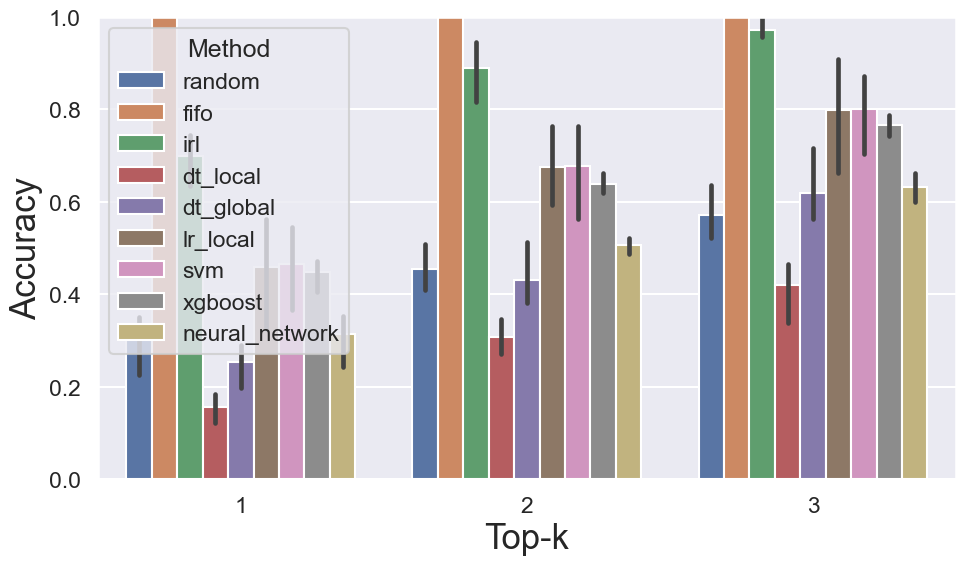

Dataset: ticket_log_EDD.csv


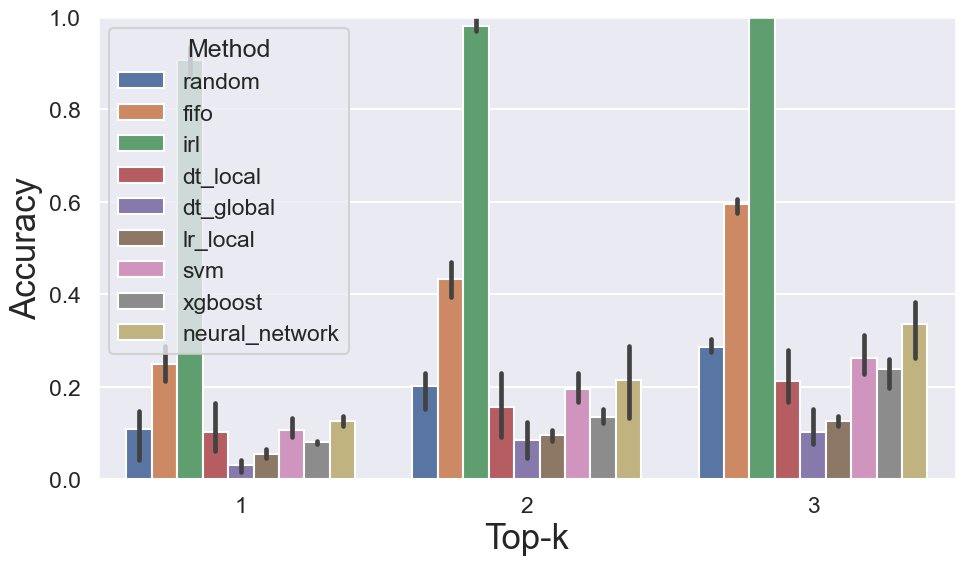

Dataset: ticket_log_platinum.csv


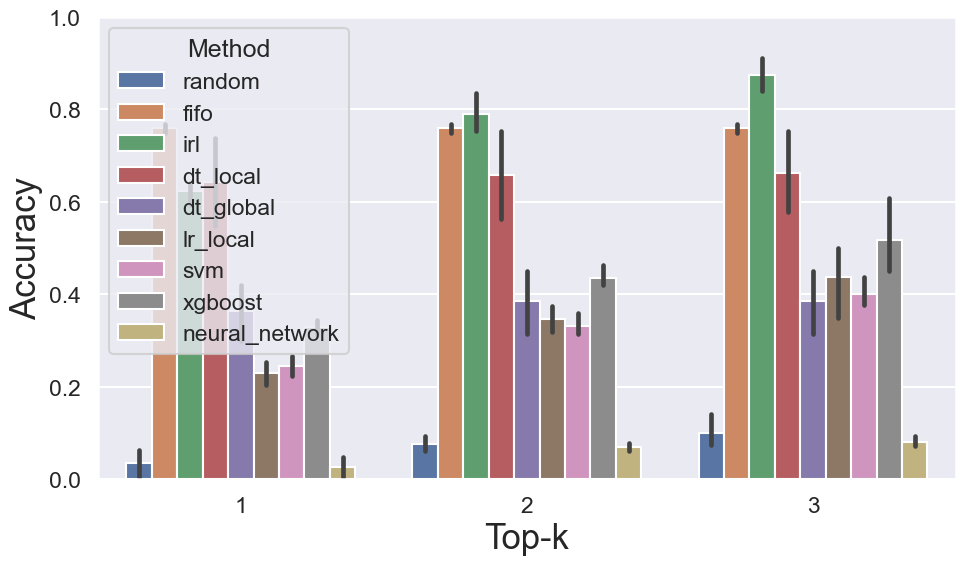

Dataset: ticket_log_random.csv


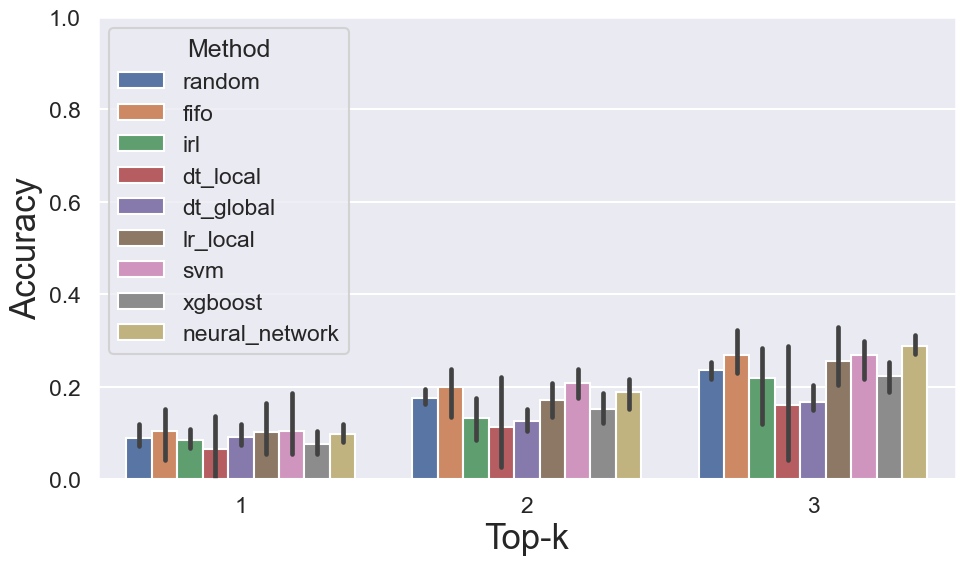

Dataset: ticket_log_SPT.csv


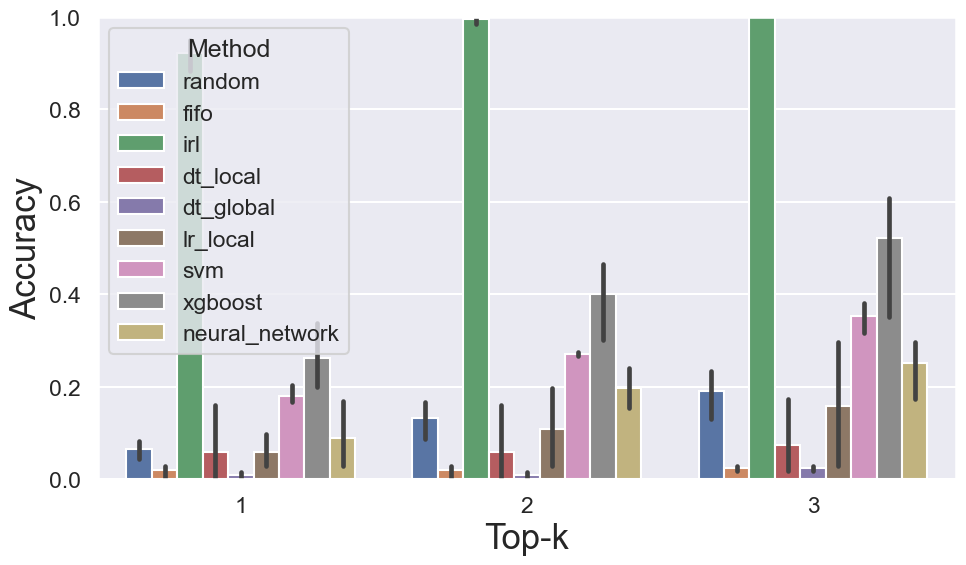

Dataset: ticket_log_value.csv


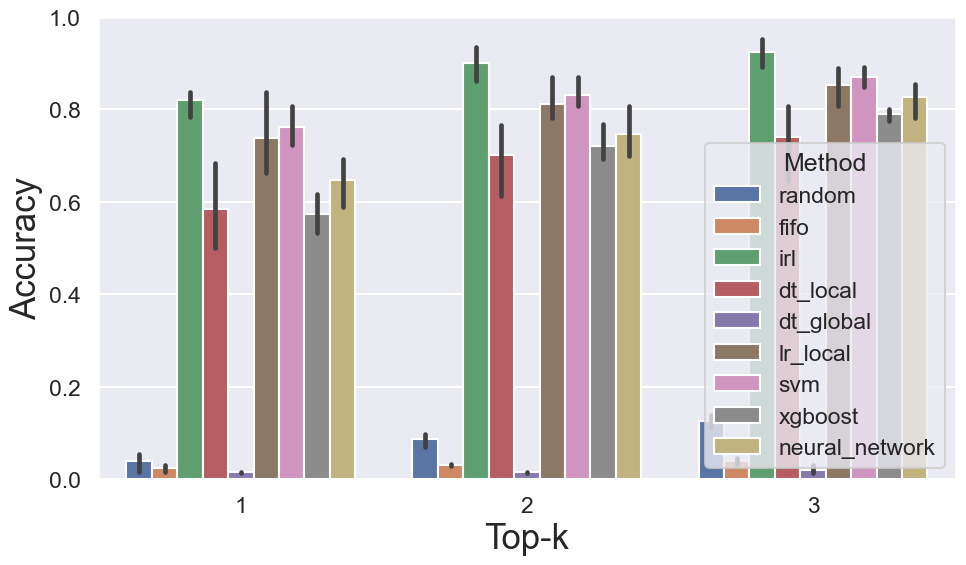

Dataset: ticket_log_base_scenario.csv


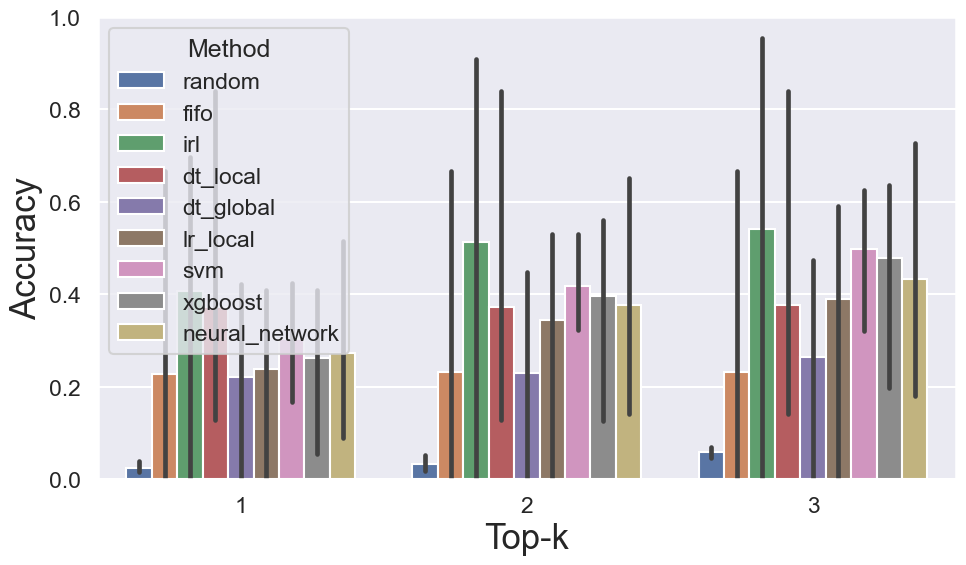

Dataset: ticket_log_diff2.csv


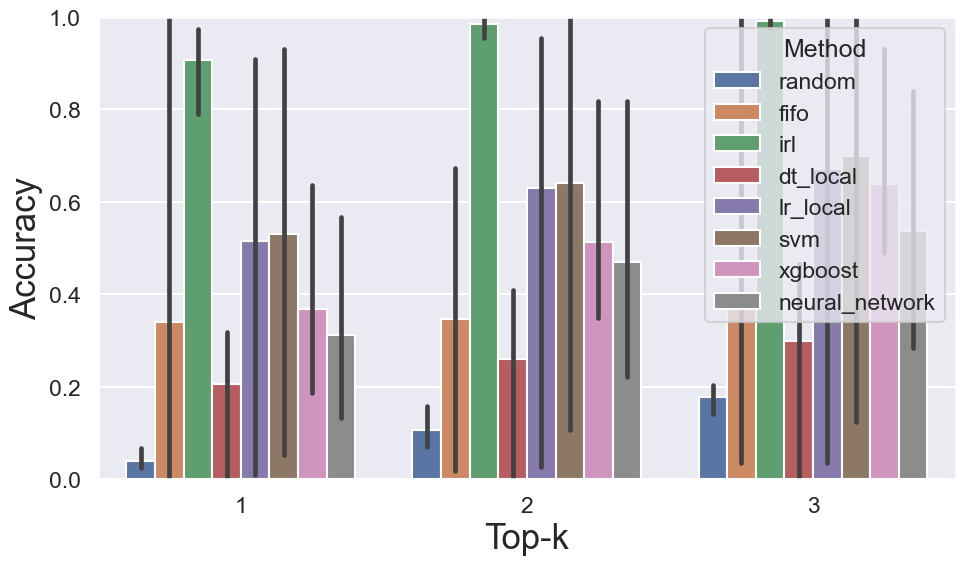

Dataset: ticket_log_level.csv


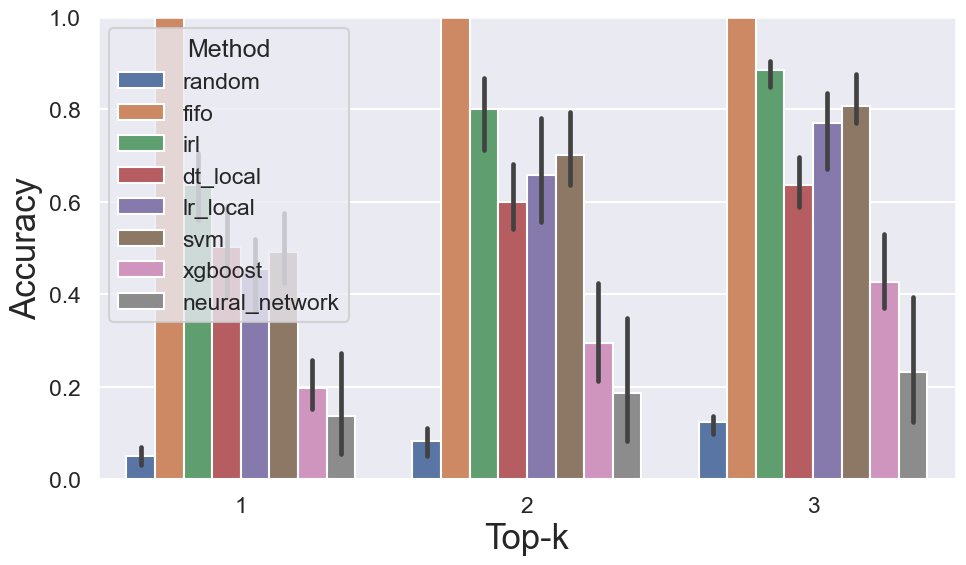

Dataset: ticket_log_platinum_2.csv


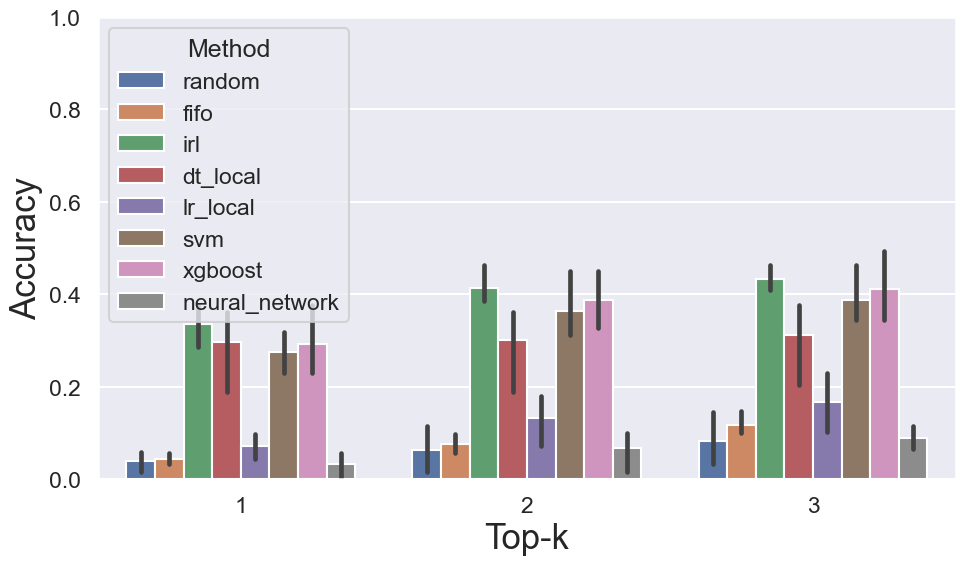


Best Results Summary with Top-k Statistics:
                     dataset         method  performance_score  avg_top1  val_avg_top1  avg_topk_accuracy  std_topk_accuracy  top1_avg  top1_std  top2_avg  top2_std  top3_avg  top3_std
          ticket_log_EDD.csv            irl             0.8861    0.9067        0.8861             0.9625             0.0492    0.9067    0.0289    0.9808    0.0167    1.0000    0.0000
          ticket_log_EDD.csv           fifo             0.2492    0.2492           NaN             0.4263             0.1735    0.2492    0.0375    0.4338    0.0383    0.5960    0.0179
          ticket_log_EDD.csv         random             0.1083    0.1083           NaN             0.1987             0.0885    0.1083    0.0585    0.2025    0.0449    0.2852    0.0156
          ticket_log_EDD.csv       dt_local             0.1025    0.1022        0.1025             0.1572             0.0551    0.1022    0.0545    0.1570    0.0695    0.2124    0.0588
          ticket_log_EDD.csv n

In [29]:
# Test the enhanced function with the current dataframe
best_results_enhanced = analyze_best_results_and_plot_enhanced(results_df)


### Results file: `results_ticket_log_10min_1000cases.csv`

,agent,method,top1_accuracy,top2_accuracy,top3_accuracy
0,Alice,DTGlobal,0.044118,0.088235,0.102941
1,Alice,DTLocal,0.058824,0.161765,0.205882
2,Alice,FIFO,0.205882,0.235294,0.264706
3,Alice,Frequentist,0.044118,0.117647,0.176471
4,Alice,IRL,0.058824,0.132353,0.176471
5,Alice,Random,0.029412,0.147059,0.161765
6,Bob,DTGlobal,0.063492,0.111111,0.126984
7,Bob,DTLocal,0.095238,0.142857,0.174603
8,Bob,FIFO,0.063492,0.126984,0.126984
9,Bob,Frequentist,0.095238,0.111111,0.174603


**Top-1 accuracy (pivot):**

method,DTGlobal,DTLocal,FIFO,Frequentist,IRL,Random
agent,,,,,,
Alice,0.044,0.059,0.206,0.044,0.059,0.029
Bob,0.063,0.095,0.063,0.095,0.095,0.000
Carol,0.101,0.145,0.014,0.043,0.928,0.043


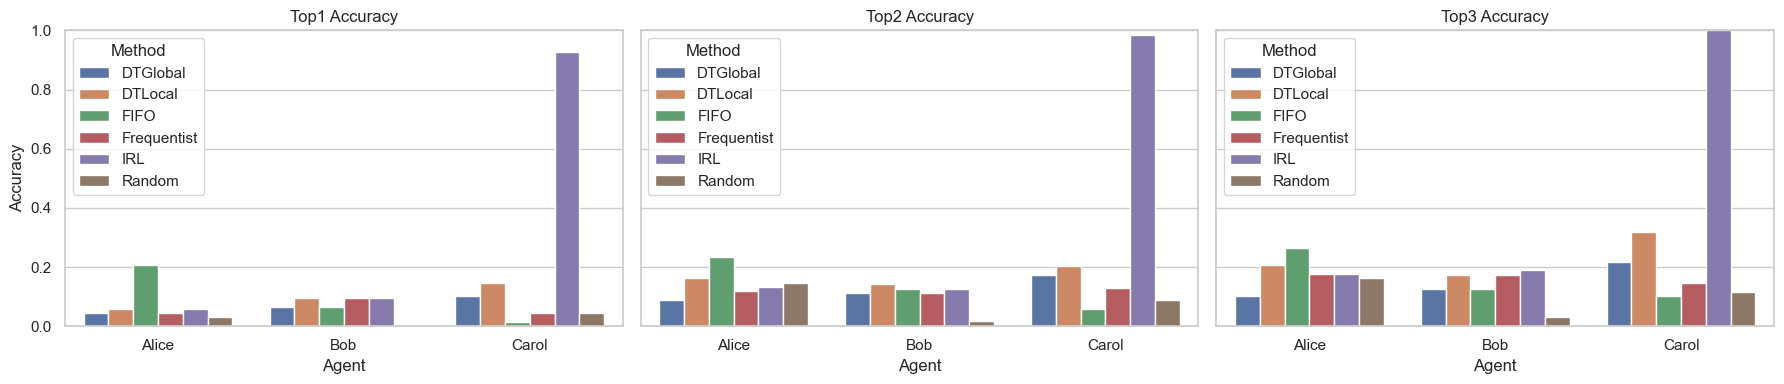

### Results file: `results_ticket_log_10min_100cases.csv`

,agent,method,top1_accuracy,top2_accuracy,top3_accuracy
0,Alice,DecisionTree,0.250000,0.750000,1.000000
1,Alice,FIFO,0.500000,1.000000,1.000000
2,Alice,Frequentist,0.500000,0.750000,1.000000
3,Alice,IRL,0.500000,1.000000,1.000000
4,Alice,Random,0.500000,0.500000,0.750000
5,Bob,DecisionTree,0.333333,0.333333,0.666667
6,Bob,FIFO,0.500000,0.500000,0.666667
7,Bob,Frequentist,0.500000,0.833333,0.833333
8,Bob,IRL,0.166667,0.833333,1.000000
9,Bob,Random,0.000000,0.333333,0.500000


**Top-1 accuracy (pivot):**

method,DecisionTree,FIFO,Frequentist,IRL,Random
agent,,,,,
Alice,0.250,0.500,0.500,0.500,0.500
Bob,0.333,0.500,0.500,0.167,0.000
Carol,0.600,0.100,0.400,0.800,0.100


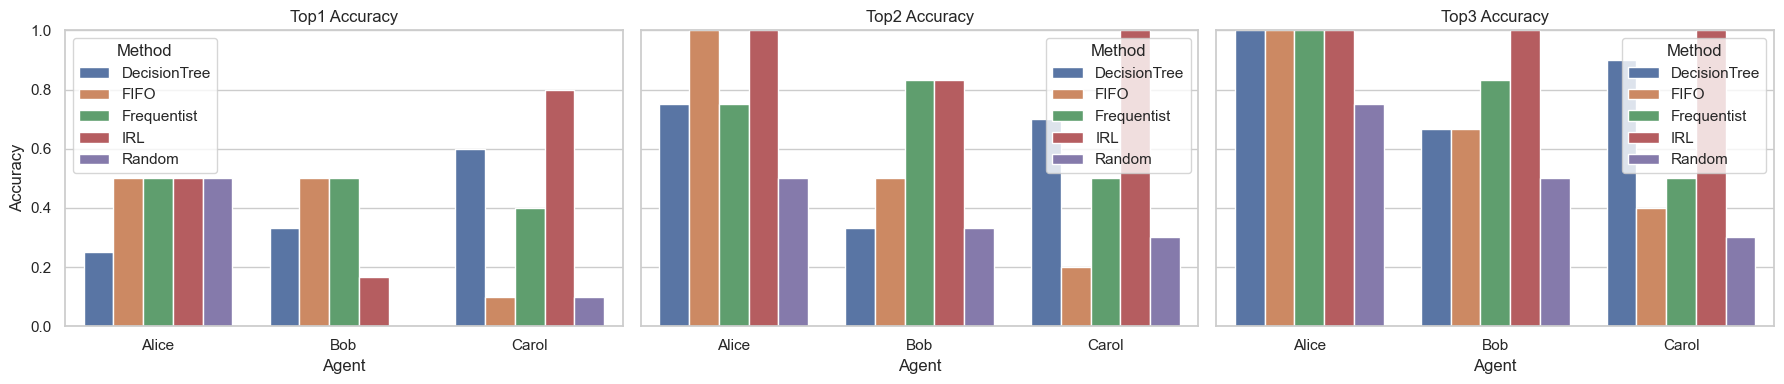

### Results file: `results_ticket_log_30min_1000cases.csv`

,agent,method,top1_accuracy,top2_accuracy,top3_accuracy
0,Alice,DTGlobal,0.121622,0.148649,0.243243
1,Alice,DTLocal,0.148649,0.202703,0.283784
2,Alice,FIFO,0.243243,0.243243,0.243243
3,Alice,Frequentist,0.135135,0.256757,0.337838
4,Alice,IRL,0.135135,0.216216,0.283784
5,Alice,Random,0.081081,0.108108,0.121622
6,Bob,DTGlobal,0.048387,0.064516,0.096774
7,Bob,DTLocal,0.112903,0.193548,0.225806
8,Bob,FIFO,0.064516,0.112903,0.161290
9,Bob,Frequentist,0.129032,0.177419,0.209677


**Top-1 accuracy (pivot):**

method,DTGlobal,DTLocal,FIFO,Frequentist,IRL,Random
agent,,,,,,
Alice,0.122,0.149,0.243,0.135,0.135,0.081
Bob,0.048,0.113,0.065,0.129,0.097,0.032
Carol,0.266,0.172,0.016,0.016,0.938,0.062


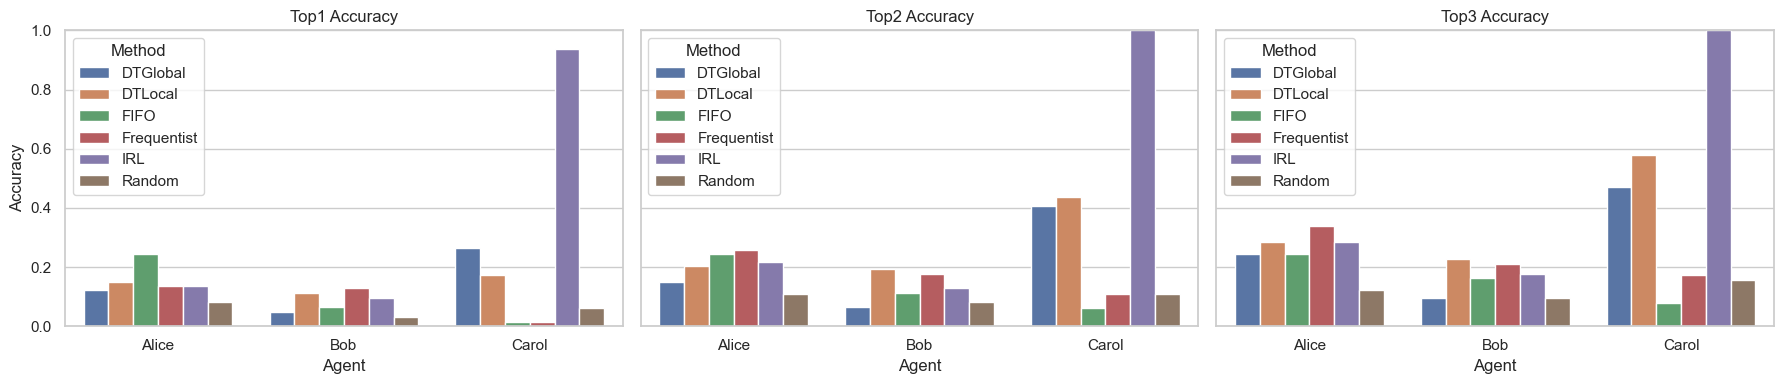

### Results file: `results_ticket_log_60min_1000cases.csv`

,agent,method,top1_accuracy,top2_accuracy,top3_accuracy
0,Alice,DTGlobal,0.567164,0.776119,0.910448
1,Alice,DTLocal,0.701493,0.895522,0.925373
2,Alice,FIFO,0.597015,0.656716,0.761194
3,Alice,Frequentist,0.731343,0.865672,0.910448
4,Alice,IRL,0.791045,0.925373,0.985075
5,Alice,Random,0.507463,0.656716,0.835821
6,Bob,DTGlobal,0.483871,0.758065,0.935484
7,Bob,DTLocal,0.612903,0.790323,0.903226
8,Bob,FIFO,0.564516,0.758065,0.838710
9,Bob,Frequentist,0.645161,0.822581,0.967742


**Top-1 accuracy (pivot):**

method,DTGlobal,DTLocal,FIFO,Frequentist,IRL,Random
agent,,,,,,
Alice,0.567,0.701,0.597,0.731,0.791,0.507
Bob,0.484,0.613,0.565,0.645,0.677,0.484
Carol,0.761,0.718,0.296,0.521,1.000,0.479


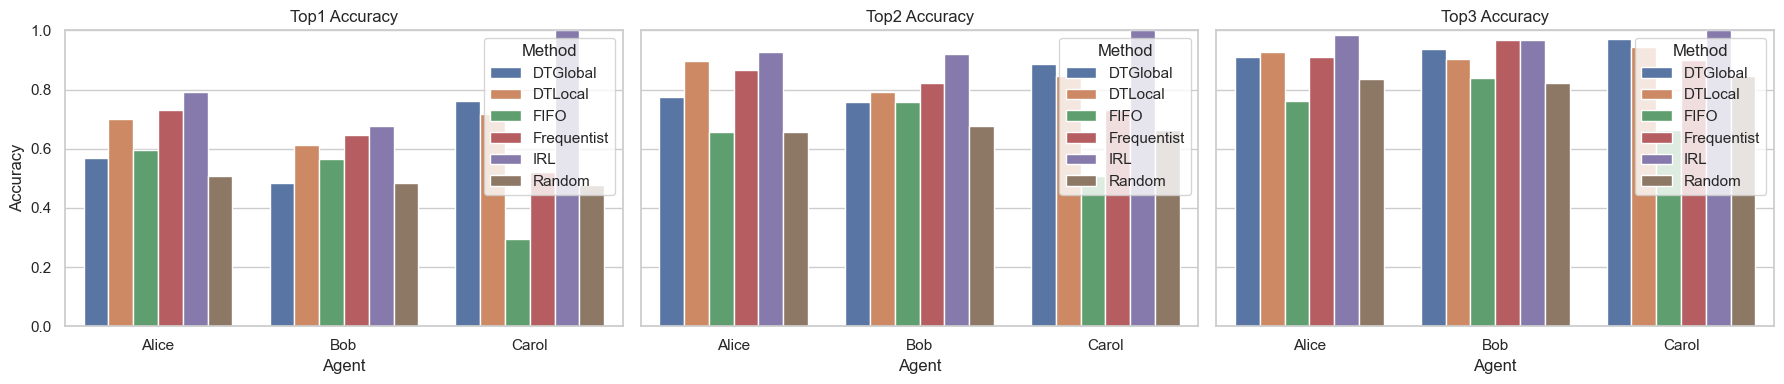

### Results file: `results_ticket_log_60min_100cases.csv`

,agent,method,top1_accuracy,top2_accuracy,top3_accuracy
0,Alice,DecisionTree,0.888889,1.0,1.0
1,Alice,FIFO,1.000000,1.0,1.0
2,Alice,Frequentist,0.777778,1.0,1.0
3,Alice,IRL,0.888889,1.0,1.0
4,Alice,Random,1.000000,1.0,1.0
5,Bob,DecisionTree,1.000000,1.0,1.0
6,Bob,FIFO,0.833333,1.0,1.0
7,Bob,Frequentist,1.000000,1.0,1.0
8,Bob,IRL,1.000000,1.0,1.0
9,Bob,Random,1.000000,1.0,1.0


**Top-1 accuracy (pivot):**

method,DecisionTree,FIFO,Frequentist,IRL,Random
agent,,,,,
Alice,0.889,1.000,0.778,0.889,1.000
Bob,1.000,0.833,1.000,1.000,1.000
Carol,1.000,0.800,0.600,1.000,0.800


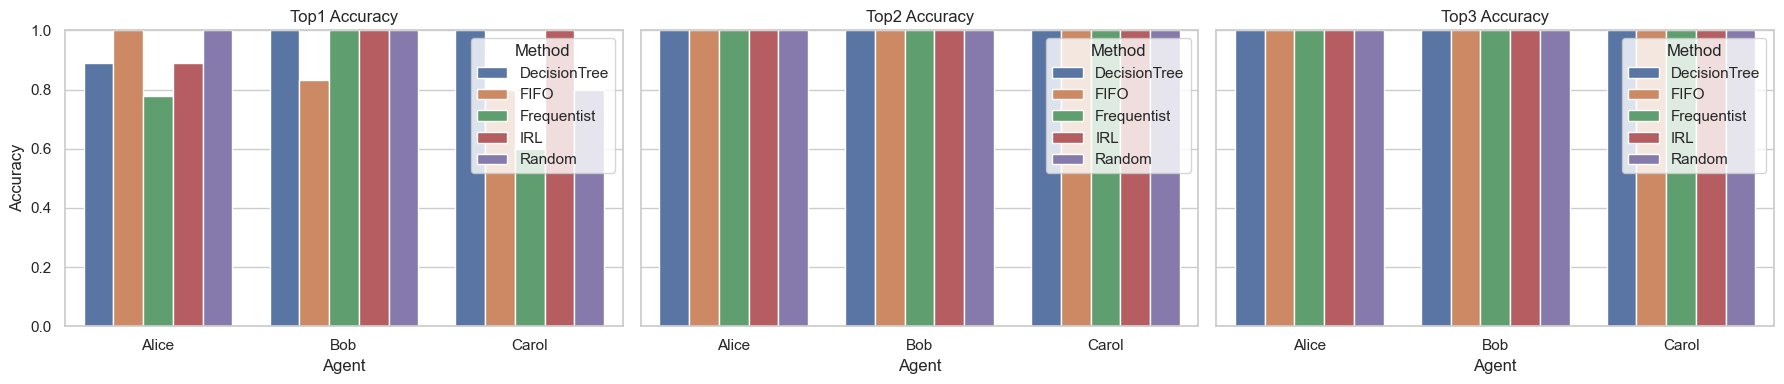

In [9]:
render_results_tables_and_plots()

In [18]:
results_df = pd.read_csv("overall_results.csv", )
results_df

,input_dataset,method,agents,agent_topk,avg_top1,val_avg_top1,seed,irl_lr,irl_epochs,irl_greedy,irl_tau,irl_weights,dt_negatives,dt_max_depth
0,ticket_log_FCFS.csv,random,"Alice,Bob,Carol","{'Alice': [0.35135135135135137, 0.445945945945...",0.307386,NaN,42,0.005,100,False,1.0,NaN,50,5.0
1,ticket_log_FCFS.csv,fifo,"Alice,Bob,Carol","{'Alice': [1.0, 1.0, 1.0], 'Bob': [1.0, 1.0, 1...",1.000000,NaN,42,0.005,100,False,1.0,NaN,50,5.0
2,ticket_log_FCFS.csv,irl,"Alice,Bob,Carol","{'Alice': [0.5675675675675675, 0.7432432432432...",0.565630,0.715012,42,0.001,100,True,1.0,"{'Alice': array([-0.11495644, 0.69345888, 0....",50,5.0
3,ticket_log_FCFS.csv,irl,"Alice,Bob,Carol","{'Alice': [0.7162162162162162, 0.9054054054054...",0.698491,0.773052,42,0.005,100,True,1.0,"{'Alice': array([-0.09836333, 0.70129986, 0....",50,5.0
4,ticket_log_FCFS.csv,irl,"Alice,Bob,Carol","{'Alice': [0.6351351351351351, 0.8108108108108...",0.579360,0.709369,42,0.010,100,True,1.0,"{'Alice': array([-0.03444281, 0.86821765, 0....",50,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,ticket_log_value.csv,neural_network,"Alice,Bob,Carol","{'Alice': [0.6935483870967742, 0.8064516129032...",0.648043,0.793496,42,0.005,100,False,1.0,NaN,50,5.0
192,ticket_log_value.csv,neural_network,"Alice,Bob,Carol","{'Alice': [0.6935483870967742, 0.8225806451612...",0.665183,0.790018,42,0.005,100,False,1.0,NaN,50,5.0
193,ticket_log_base_scenario.csv,neural_network,"Alice,Bob,Carol","{'Alice': [0.01282051282051282, 0.012820512820...",0.165890,0.268049,42,0.005,100,False,1.0,NaN,50,5.0
194,ticket_log_base_scenario.csv,neural_network,"Alice,Bob,Carol","{'Alice': [0.01282051282051282, 0.012820512820...",0.175991,0.307412,42,0.005,100,False,1.0,NaN,50,5.0


Dataset: ticket_log_FCFS.csv


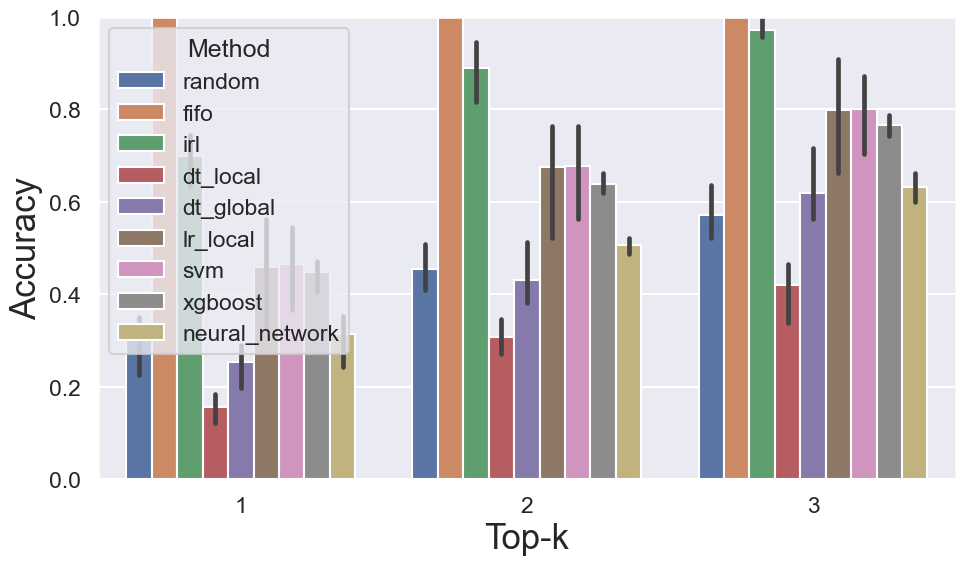

Dataset: ticket_log_EDD.csv


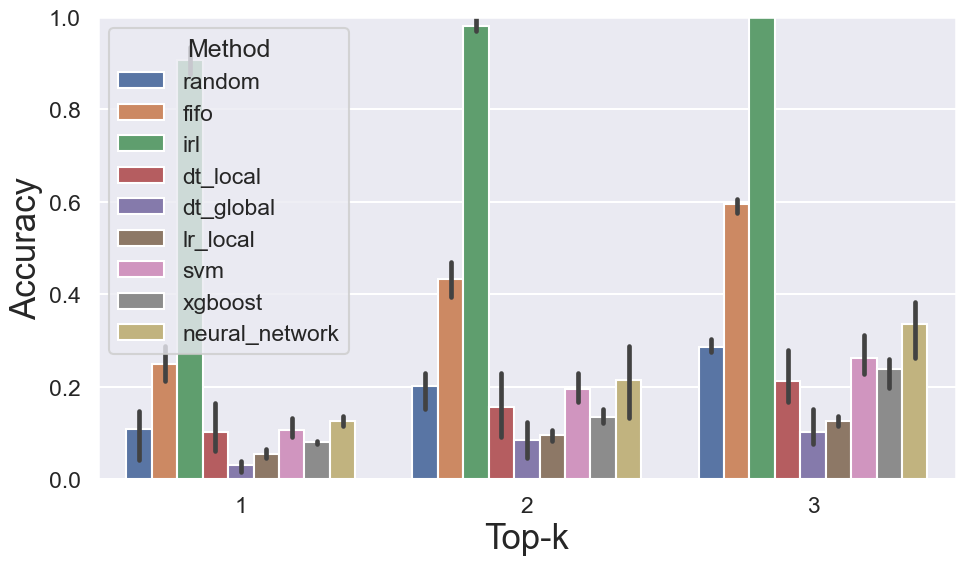

Dataset: ticket_log_platinum.csv


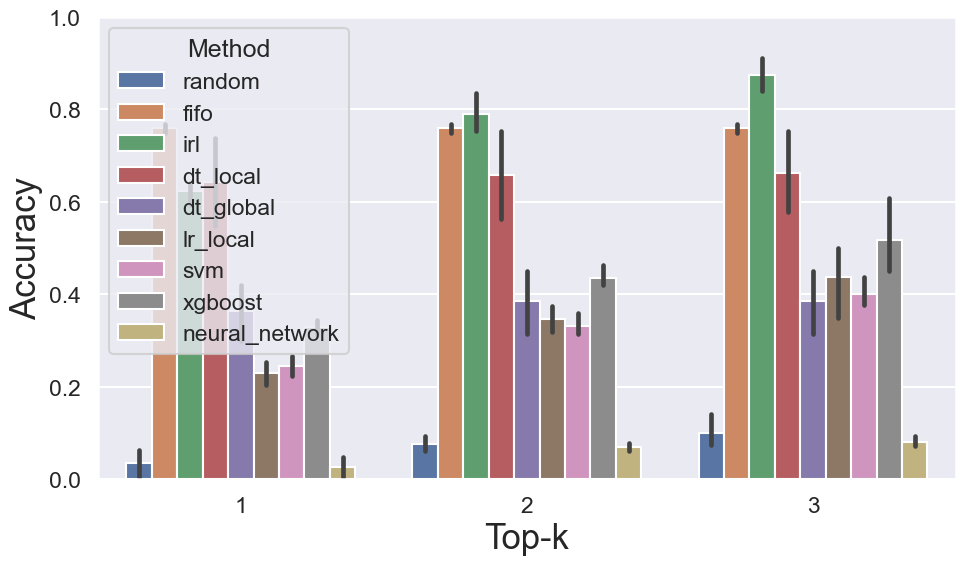

Dataset: ticket_log_random.csv


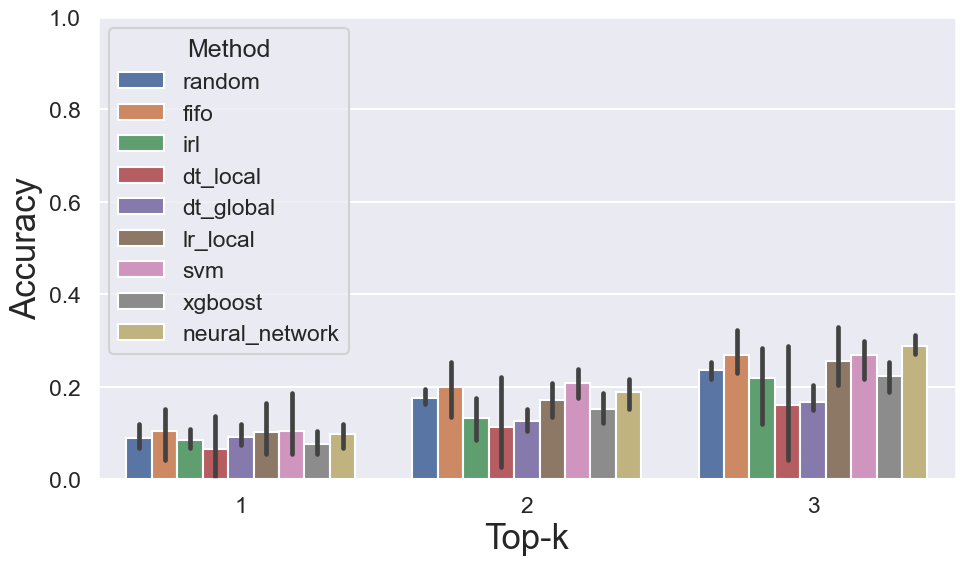

Dataset: ticket_log_SPT.csv


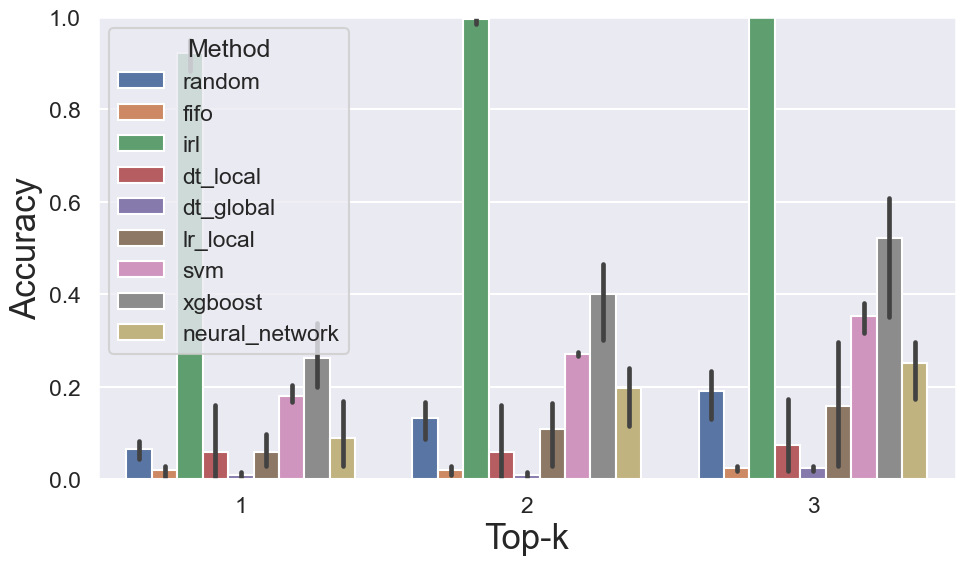

Dataset: ticket_log_value.csv


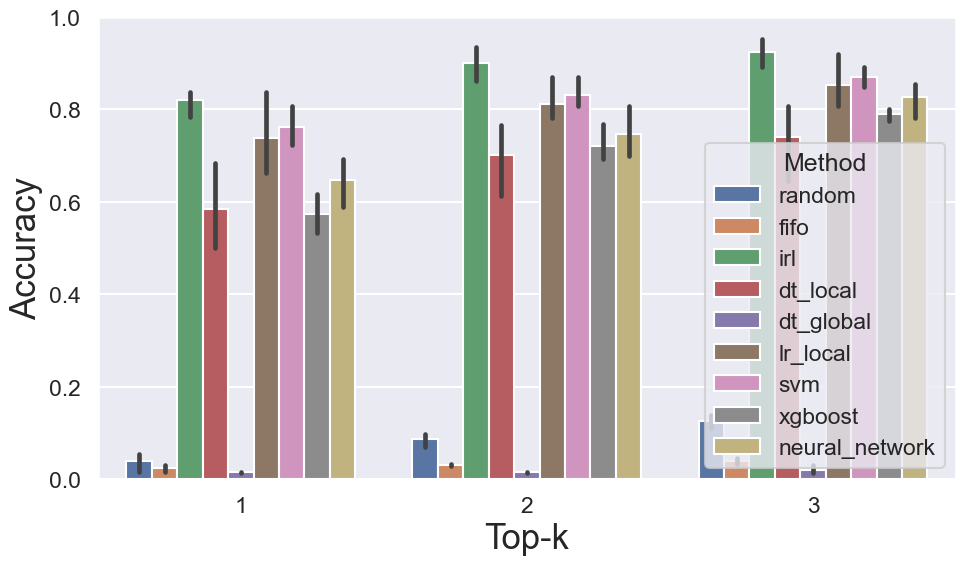

Dataset: ticket_log_base_scenario.csv


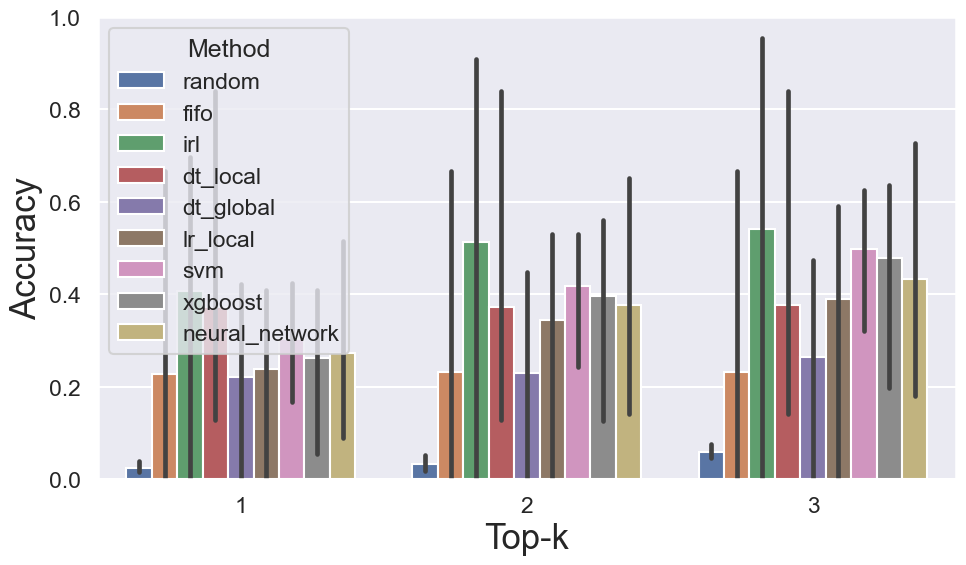


Best Results Summary:
                     dataset         method  performance_score  avg_top1  val_avg_top1
          ticket_log_EDD.csv            irl           0.886075  0.906743      0.886075
          ticket_log_EDD.csv           fifo           0.249190  0.249190           NaN
          ticket_log_EDD.csv         random           0.108334  0.108334           NaN
          ticket_log_EDD.csv       dt_local           0.102491  0.102244      0.102491
          ticket_log_EDD.csv neural_network           0.080314  0.124802      0.080314
          ticket_log_EDD.csv        xgboost           0.064919  0.079972      0.064919
          ticket_log_EDD.csv      dt_global           0.058530  0.029678      0.058530
          ticket_log_EDD.csv            svm           0.058190  0.105982      0.058190
          ticket_log_EDD.csv       lr_local           0.012043  0.055274      0.012043
         ticket_log_FCFS.csv           fifo           1.000000  1.000000           NaN
         ticket_log_

In [19]:
def analyze_best_results_and_plot(df):
    """
    Analyzes the dataframe to find the best performing result per method per dataset,
    then plots the agent_topk values.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with columns including input_dataset, method, 
                       val_avg_top1, avg_top1, and agent_topk
    
    Returns:
    pd.DataFrame: DataFrame with best results per method per dataset
    """
    import ast
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme("talk")
    
    # Create a copy to avoid modifying the original
    df_work = df.copy()
    
    # Create a performance score column - use val_avg_top1 if available, otherwise avg_top1
    df_work['performance_score'] = df_work['val_avg_top1'].fillna(df_work['avg_top1'])
    
    # Group by input_dataset and method, then get the best performing result for each
    best_results = []
    
    for dataset in df_work['input_dataset'].unique():
        dataset_data = df_work[df_work['input_dataset'] == dataset]
        
        for method in dataset_data['method'].unique():
            method_data = dataset_data[dataset_data['method'] == method]
            
            # Find the row with the highest performance score
            best_idx = method_data['performance_score'].idxmax()
            best_row = method_data.loc[best_idx].copy()
            best_row['dataset'] = dataset
            best_results.append(best_row)
    
    # Convert to DataFrame
    best_results_df = pd.DataFrame(best_results)
    
    # Parse agent_topk values and create visualization data
    plot_data = []
    
    for _, row in best_results_df.iterrows():
        try:
            # Parse the agent_topk string
            agent_topk_str = row['agent_topk']
            agent_topk_dict = ast.literal_eval(agent_topk_str)
            
            # Extract data for each agent
            for agent, topk_values in agent_topk_dict.items():
                for k, value in enumerate(topk_values, 1):
                    plot_data.append({
                        'dataset': row['dataset'],
                        'method': row['method'],
                        'agent': agent,
                        'k': k,
                        'accuracy': value,
                        'performance_score': row['performance_score']
                    })
        except Exception as e:
            print(f"Error parsing agent_topk for {row['dataset']}, {row['method']}: {e}")
            continue
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create the visualization
    if not plot_df.empty:
        # Create individual plots for each dataset
        datasets = plot_df['dataset'].unique()
        
        for dataset in datasets:
            print(f"Dataset: {dataset}")
            dataset_data = plot_df[plot_df['dataset'] == dataset]
            
            # Create a new figure for each dataset
            plt.figure(figsize=(10, 6))
            
            # Create a grouped bar plot
            sns.barplot(data=dataset_data, x='k', y='accuracy', hue='method')
            # plt.title(f'Top-k Accuracy by Method - Dataset: {dataset}', fontsize=14, fontweight='bold')
            plt.xlabel('Top-k', fontsize=25)
            plt.ylabel('Accuracy', fontsize=25)
            plt.ylim(0, 1)
            plt.legend(title='Method', loc='best')
            
            # # Add performance scores as text annotations
            # for method in dataset_data['method'].unique():
            #     method_data = dataset_data[dataset_data['method'] == method]
            #     perf_score = method_data['performance_score'].iloc[0]
            #     plt.text(0.02, 0.98, f'{method}: {perf_score:.3f}', 
            #             transform=plt.gca().transAxes, verticalalignment='top',
            #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
        
        # Also create a summary table
        print("\nBest Results Summary:")
        print("=" * 80)
        summary_cols = ['dataset', 'method', 'performance_score', 'avg_top1', 'val_avg_top1']
        summary_df = best_results_df[summary_cols].sort_values(['dataset', 'performance_score'], ascending=[True, False])
        print(summary_df.to_string(index=False))
        
    return best_results_df

# Test the function with the current dataframe
best_results = analyze_best_results_and_plot(results_df)


/var/folders/45/0s1q3ns54cv9jj1ss_41vx2r0000gn/T/ipykernel_21521/4218521760.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=20)


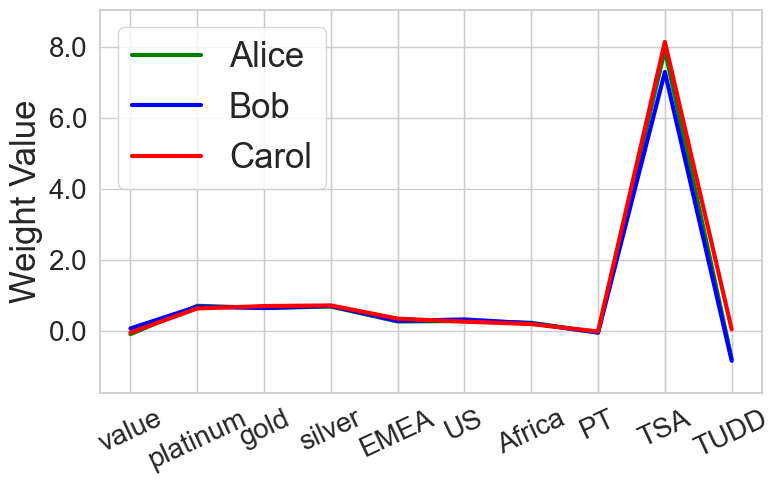

In [15]:
def plot_irl_weights_parallel_coordinates(df):
    """
    Creates a parallel coordinates plot of IRL weights for Alice, Bob, and Carol.
    For each dataset, selects the IRL result with the highest val_avg_top1 score.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with columns including input_dataset, method, 
                       val_avg_top1, avg_top1, and irl_weights
    """
    import ast
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import to_rgba
    import re

    sns.set_theme("talk")
    sns.set(style="whitegrid")
    
    # Filter for IRL method only
    irl_df = df[df['method'] == 'irl'].copy()
    
    if irl_df.empty:
        print("No IRL results found in the dataframe.")
        return
    
    # Create performance score column
    irl_df['performance_score'] = irl_df['val_avg_top1'].fillna(irl_df['avg_top1'])
    
    # Get best IRL result per dataset
    best_irl_results = []
    
    for dataset in irl_df['input_dataset'].unique():
        if dataset == 'ticket_log_FCFS.csv':
            dataset_data = irl_df[irl_df['input_dataset'] == dataset]
            
            # Find the row with the highest performance score
            best_idx = dataset_data['performance_score'].idxmax()
            best_row = dataset_data.loc[best_idx].copy()
            best_row['dataset'] = dataset
            best_irl_results.append(best_row)
    
    best_irl_df = pd.DataFrame(best_irl_results)
    
    # Parse IRL weights and prepare data for parallel coordinates
    plot_data = []
    
    for _, row in best_irl_df.iterrows():
        try:
            # Parse the irl_weights string
            weights_str = row['irl_weights']
            
            # Preprocess the string to replace array() calls with just the list
            def preprocess_array_string(s):
                """Replace array([...]) with [...] to make it ast.literal_eval compatible"""
                s = re.sub(r'array\(\[', '[', s)
                s = re.sub(r'\]\)', ']', s)
                return s
            
            processed_str = preprocess_array_string(weights_str)
            weights_dict = ast.literal_eval(processed_str)
            
            # Extract weights for each agent
            alice_weights = np.array(weights_dict['Alice'])
            bob_weights = np.array(weights_dict['Bob'])
            carol_weights = np.array(weights_dict['Carol'])
            
            # Create data for parallel coordinates
            # Each weight dimension becomes a coordinate
            for i in range(len(alice_weights)):
                plot_data.append({
                    'dataset': row['dataset'],
                    'agent': 'Alice',
                    'weight_dim': i,
                    'weight_value': alice_weights[i],
                    'performance_score': row['performance_score']
                })
                plot_data.append({
                    'dataset': row['dataset'],
                    'agent': 'Bob', 
                    'weight_dim': i,
                    'weight_value': bob_weights[i],
                    'performance_score': row['performance_score']
                })
                plot_data.append({
                    'dataset': row['dataset'],
                    'agent': 'Carol',
                    'weight_dim': i,
                    'weight_value': carol_weights[i],
                    'performance_score': row['performance_score']
                })
                
        except Exception as e:
            print(f"Error parsing irl_weights for {row['dataset']}: {e}")
            continue
    
    if not plot_data:
        print("No valid IRL weights data found.")
        return
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create parallel coordinates plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Get unique datasets and assign colors
    datasets = plot_df['dataset'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(datasets)))
    dataset_colors = dict(zip(datasets, colors))
    
    # Get weight dimensions and names
    dimension_names = ['value', 'platinum', 'gold', 'silver', 'EMEA', 'US', 'Africa', 'PT', 'TSA', 'TUDD']
    weight_dims = list(range(len(dimension_names)))
    n_dims = len(weight_dims)
    
    # Determine y-limits with a margin for better aesthetics
    y_min = plot_df['weight_value'].min()
    y_max = plot_df['weight_value'].max()
    y_pad = 0.1 * max(1e-6, (y_max - y_min))
    ax.set_ylim(y_min - y_pad, y_max + y_pad)
    
    # Add vertical lines for each dimension
    for x in weight_dims:
        ax.axvline(x=x, color='lightgray', linewidth=1, alpha=0.7, zorder=0)
    
    # Create parallel coordinates
    for dataset in datasets:
        dataset_data = plot_df[plot_df['dataset'] == dataset]
        color = dataset_colors[dataset]
        colors = ['green', 'blue', 'red']
        t=0
        
        # Plot lines for each agent
        for agent in ['Alice', 'Bob', 'Carol']:
            color = colors[t]
            t+=1
            agent_data = dataset_data[dataset_data['agent'] == agent]
            
            if not agent_data.empty:
                # Sort by weight dimension
                agent_data = agent_data.sort_values('weight_dim')
                
                # Plot the line
                line_style = '-' #if agent == 'Alice' else '--' if agent == 'Bob' else ':'
                line_width = 3 # if agent == 'Alice' else 1.5 if agent == 'Bob' else 1
                
                ax.plot(agent_data['weight_dim'], agent_data['weight_value'], 
                       color=color, linestyle=line_style, linewidth=line_width, 
                       alpha=1, label=f'{dataset} - {agent}' if agent == 'Alice' else "")
    
    # Customize the plot
    # ax.set_xlabel('Weight Dimension', fontsize=25)
    ax.set_ylabel('Weight Value', fontsize=25)
    ax.set_yticklabels(ax.get_yticks(), fontsize=20)
    # ax.set_title('IRL Weights Parallel Coordinates Plot\n(Best performing IRL result per dataset)', 
    #             fontsize=14, fontweight='bold')
    
    # Set x-axis ticks and labels
    ax.set_xticks(weight_dims,)
    ax.set_xticklabels(dimension_names, rotation=25, fontsize=20)
    
    # Add grid
    ax.grid(True, alpha=1)
    
    # Create custom legend
    legend_elements = []
    
    # Add dataset colors
    # for dataset, color in dataset_colors.items():
    #     legend_elements.append(plt.Line2D([0], [0], color=color, linewidth=3, label=dataset))
    
    # Add agent line styles
    legend_elements.extend([
        plt.Line2D([0], [0], color=colors[0], linewidth=3, linestyle='-', label='Alice'),
        plt.Line2D([0], [0], color=colors[1], linewidth=3, linestyle='-', label='Bob'),
        plt.Line2D([0], [0], color=colors[2], linewidth=3, linestyle='-', label='Carol')
    ])
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=25)
    
    plt.tight_layout()
    plt.show()
    
    return best_irl_df

# Test the function with the current dataframe
best_irl_results = plot_irl_weights_parallel_coordinates(results_df)


In [ ]:
# get the irl_weights column
results_df['agent_topk'][0]

"{'Alice': [0.7162162162162162, 0.9054054054054054, 0.9594594594594594], 'Bob': [0.6338028169014085, 0.8169014084507042, 0.9577464788732394], 'Carol': [0.7454545454545455, 0.9454545454545454, 1.0]}"

In [ ]:
# Method 1: Using eval() to convert string back to dictionary
import ast
import numpy as np
import re

# Get the string representation
weights_str = results_df['irl_weights'][0]
print("Original string:")
print(weights_str)
print("\n" + "="*50 + "\n")

# Method 1a: Preprocess the string to replace array() calls with just the list
def preprocess_array_string(s):
    """Replace array([...]) with [...] to make it ast.literal_eval compatible"""
    # Replace array([ with [
    s = re.sub(r'array\(\[', '[', s)
    # Replace ]) with ]
    s = re.sub(r'\]\)', ']', s)
    return s

# Preprocess the string
processed_str = preprocess_array_string(weights_str)
print("Processed string:")
print(processed_str)
print("\n" + "="*50 + "\n")

# Now use ast.literal_eval
weights_dict = ast.literal_eval(processed_str)

# Extract individual arrays
alice_weights = np.array(weights_dict['Alice'])
carol_weights = np.array(weights_dict['Carol'])
bob_weights = np.array(weights_dict['Bob'])

print("Alice's weights:", alice_weights)
print("Carol's weights:", carol_weights)
print("Bob's weights:", bob_weights)


Original string:
{'Alice': array([-0.09836333,  0.70129986,  0.64247407,  0.68054375,  0.26026627,
        0.27221809,  0.22266971, -0.04989558,  7.92835068, -0.79650415]), 'Carol': array([-0.05292931,  0.62737341,  0.69468769,  0.71296489,  0.34089347,
        0.25478336,  0.18599847, -0.02202697,  8.15386791,  0.03888627]), 'Bob': array([ 0.06297323,  0.67928608,  0.63965095,  0.69874213,  0.27475566,
        0.31777984,  0.20698557, -0.05501226,  7.30519316, -0.84938761])}


Processed string:
{'Alice': [-0.09836333,  0.70129986,  0.64247407,  0.68054375,  0.26026627,
        0.27221809,  0.22266971, -0.04989558,  7.92835068, -0.79650415], 'Carol': [-0.05292931,  0.62737341,  0.69468769,  0.71296489,  0.34089347,
        0.25478336,  0.18599847, -0.02202697,  8.15386791,  0.03888627], 'Bob': [ 0.06297323,  0.67928608,  0.63965095,  0.69874213,  0.27475566,
        0.31777984,  0.20698557, -0.05501226,  7.30519316, -0.84938761]}


Alice's weights: [-0.09836333  0.70129986  0.64247407 